# Unemployment Models
Brian Howard
26 July 2020

In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
library(readr)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
#install.packages("EIAdata")
library(EIAdata)
library(gtable)
library(data.table)
library(readxl)
library(plotly)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats'

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
d.GSPC.max = 3500

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [85]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [10]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [11]:
source("calcFeatures.r")

In [12]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "SRPSABSNNCB has zero or negative values. Log series will be zero."
[1] "TNX.Volume has zero or negative values. Log series will be zero."
[1] "CLF.Low has zero or negative values. Log series will be zero."
[1] "CLF.Close has zero or negative values. Log series will be zero."
[1] "CLF.Volume has zero or negative values. Log series will be zero."
[1] "CLF.Adjusted has zero or negative values. Log series will be zero."
[1] "DTB3 has zero or negative values. Log series will be zero."
[1] "IRX.Open has zero or negative values. Log series will be zero."
[1] "IRX.High has zero or negative values. Log series will be zero."
[1] "IRX.Low has zero or negative values. Log series will be zero."
[1] "IRX.Close has zero or negative values. Log series will be zero."
[1] "IRX.Volume has zero or negative values. Log series will be zero."
[1] "IRX.Adjusted has zero or negative values. Log series will be zero."
[1] "DCOILWTICO has zero

These are auxilliary series that use the YoY and smoothed data.

In [13]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [14]:
source("calcRecession.r")


## Historical statistics

### Year over year


How much did the market change in a year, or 4, or 5? This data is used to evaluate the probability of a XX% decline in a certain period.

Start with year-over-year

In [ ]:
datay.in <- "GSPC.Close_YoY"
datay.aux.1 <- "DJI.Close_YoY"
datay.aux.2 <- "RLG.Close_YoY"
ylim.in <- c(-75, 75)
dt.start <- as.Date('1940-01-01')
p1 <- plotSingle(datadf_rec=dfRecession,
           datadf=df.data,
           datax="date",
           datay = datay.in,
           titlelabel = getPlotTitle(df.symbols, datay.in),
           xlabel = "Date",
           ylabel = getPlotYLabel(df.symbols, datay.in),
           xlim = c(dt.start, Sys.Date()),
           ylim = ylim.in,
           b.legend = TRUE,
           b.percentile = TRUE,
           b.long.legend = TRUE) 
p1 <-p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(datay.aux.1)
  ),
  na.rm = TRUE
)

p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(datay.aux.2)
  ),
  na.rm = TRUE
)

## Unployment models

### Labor force normalization

The BLS statistics (U3, U6, etc.) calculates labor force by summing the number of employed and unemployed people (https://www.bls.gov/cps/lfcharacteristics.htm#laborforce). The problem is that when the survey is troubled, as it was during Covid19, the labor force shows a sudden drop. For example, during the Covid19 outbreak in the spring of 2020 the labor force dropped from 164MM to 155MM. In reality, the labor force did not really drop by this much. In other words there were approximately the same number of people who wanted to work on March 1st of 2020 as there were on June 1st of 2020.

This makes the BLS measures of labor force less useful when I want to normalized by working force population. To get around this I do a linear fit of BLS labor force to general U.S. population (POPTHM) and take the slope of that fit as the average labor force participation rate. I then multiply POPTHM this value to get a constant labor force rate. This has some drawbacks, especially in that it cannot account for demographic shifts. But it should be an okay first order approximation.

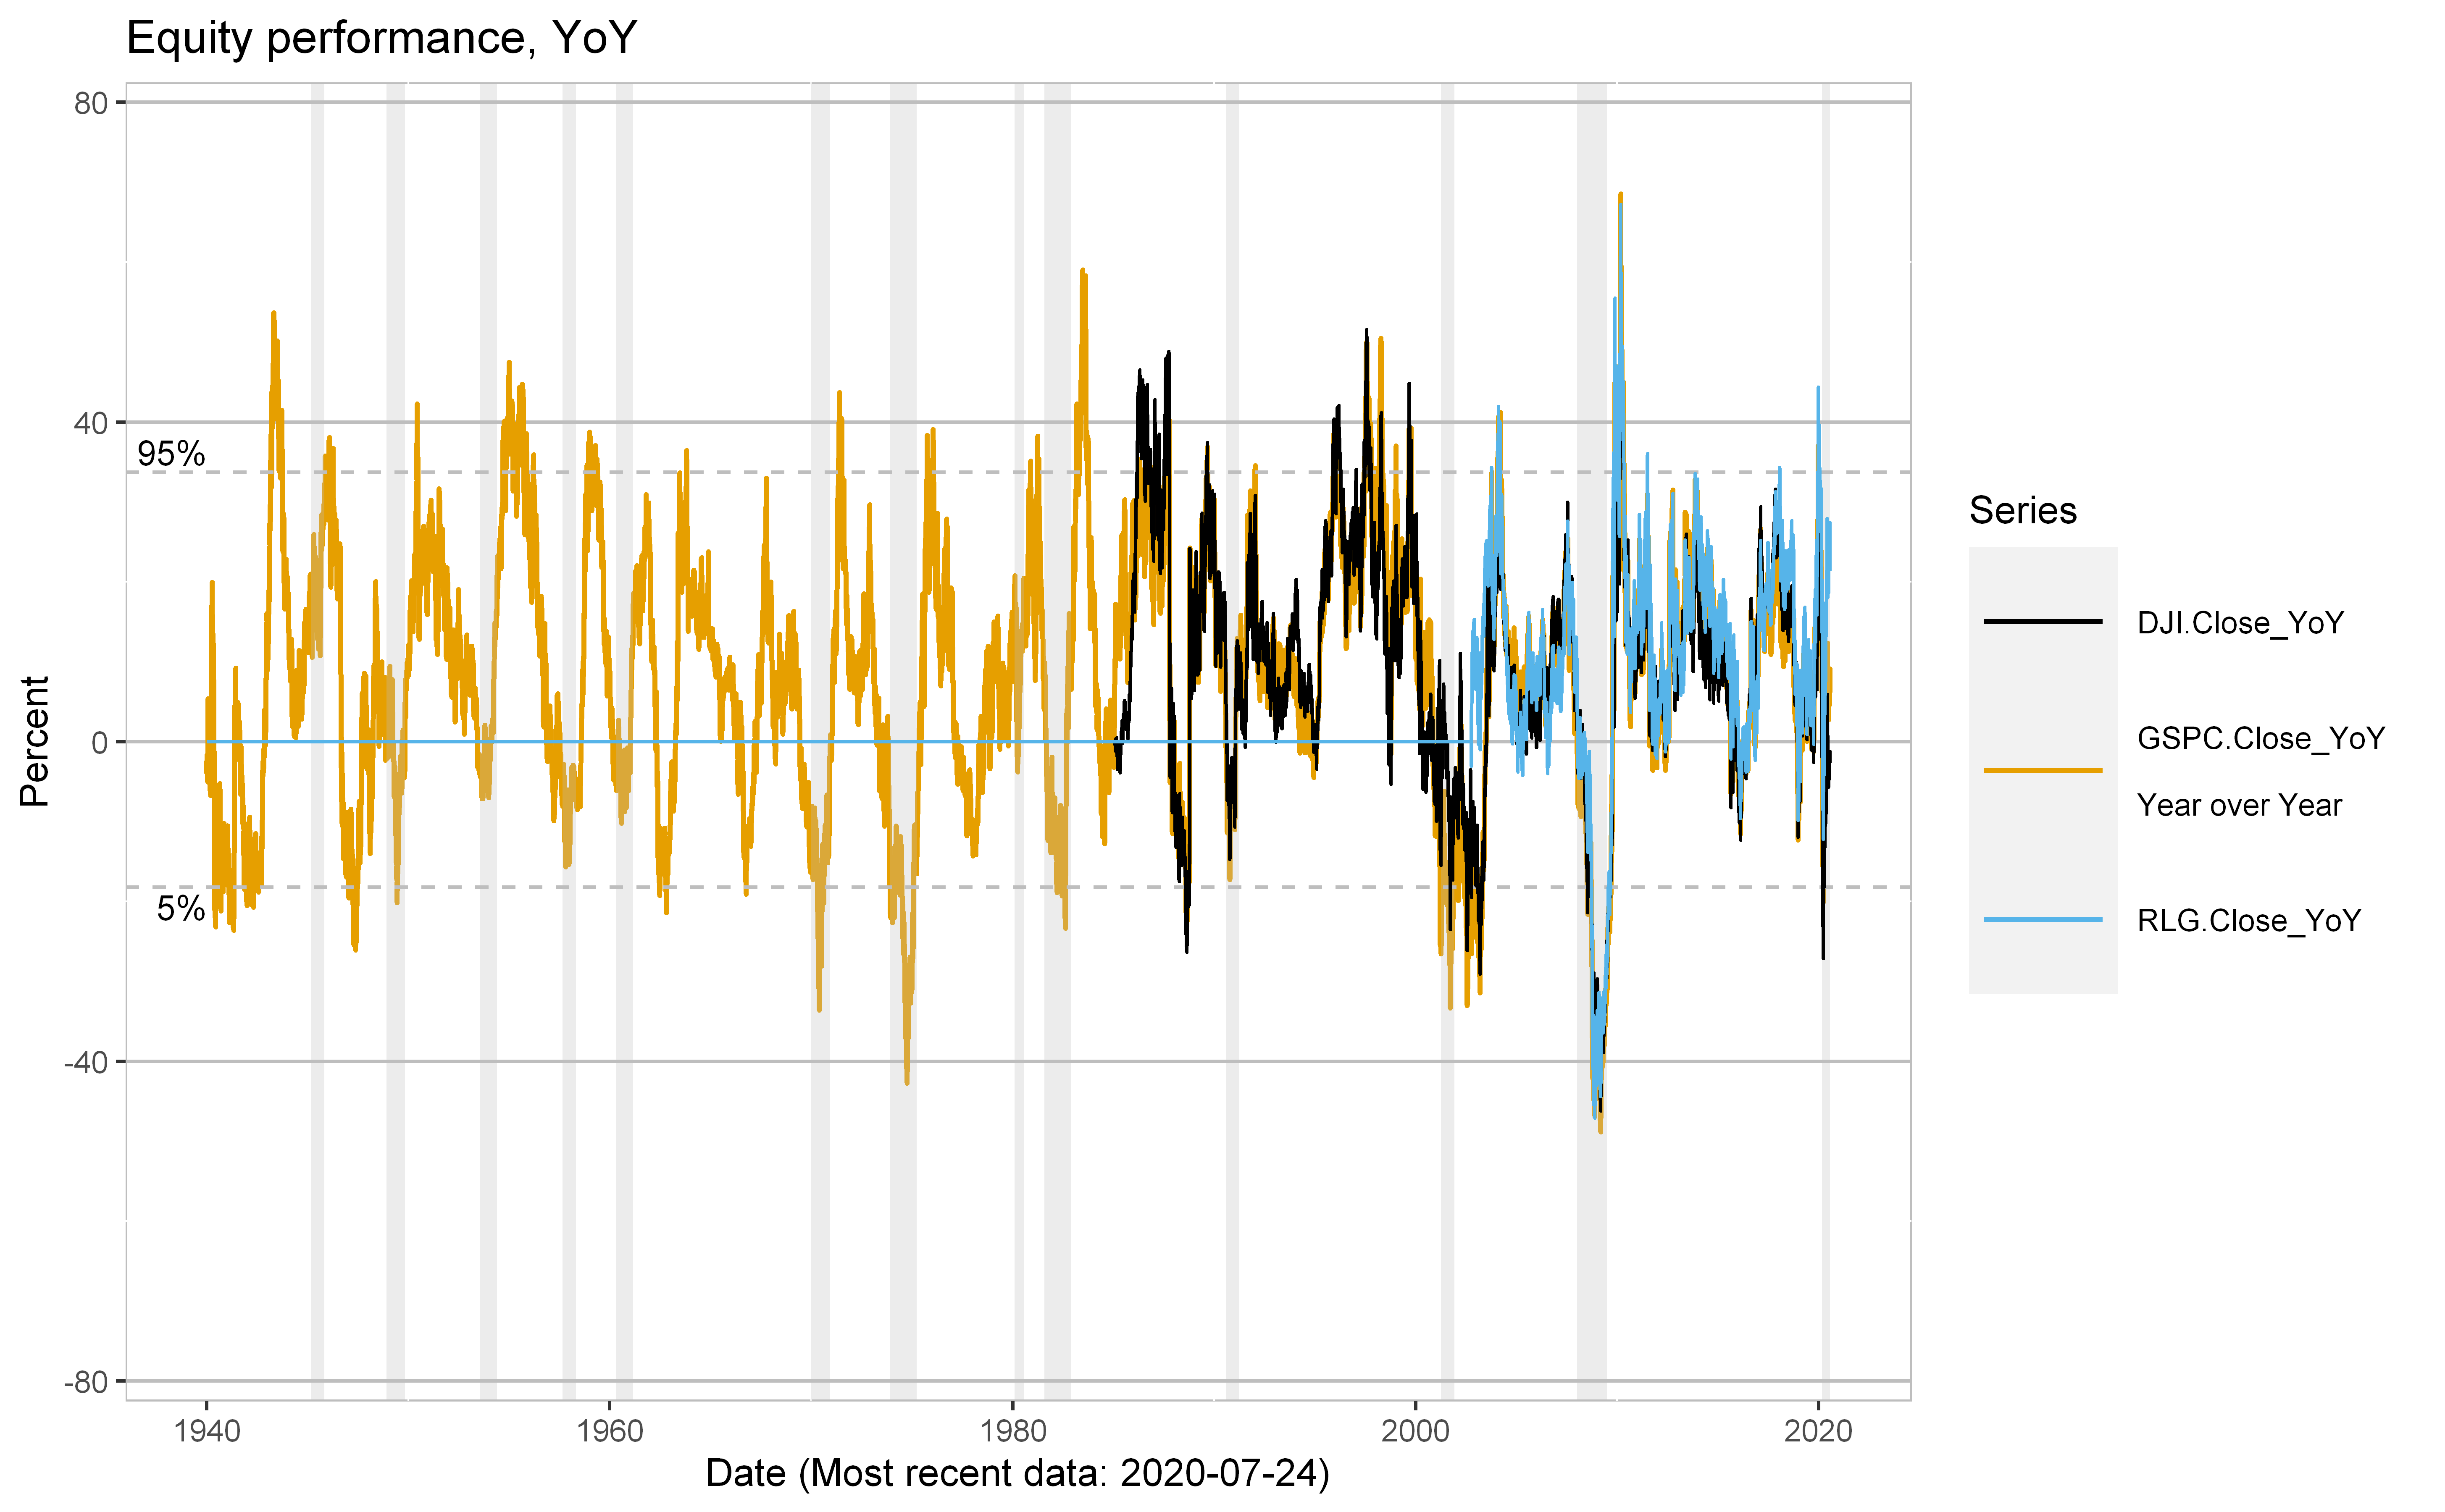

In [72]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay.in <- "GSPC.Close_YoY"
datay.aux.1 <- "DJI.Close_YoY"
datay.aux.2 <- "RLG.Close_YoY"
ylim.in <- c(-75, 75)
dt.start <- as.Date('1940-01-01')
p1 <- plotSingle(datadf_rec=dfRecession,
           datadf=df.data,
           datax="date",
           datay = datay.in,
           titlelabel = "Equity performance, YoY",
           xlabel = "Date",
           ylabel = getPlotYLabel(df.symbols, datay.in),
           xlim = c(dt.start, Sys.Date()),
           ylim = ylim.in,
           b.legend = TRUE,
           b.percentile = TRUE,
           b.long.legend = TRUE) 
p1 <-p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(datay.aux.1)
  ),
  na.rm = TRUE
)

p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(datay.aux.2)
  ),
  na.rm = TRUE
)

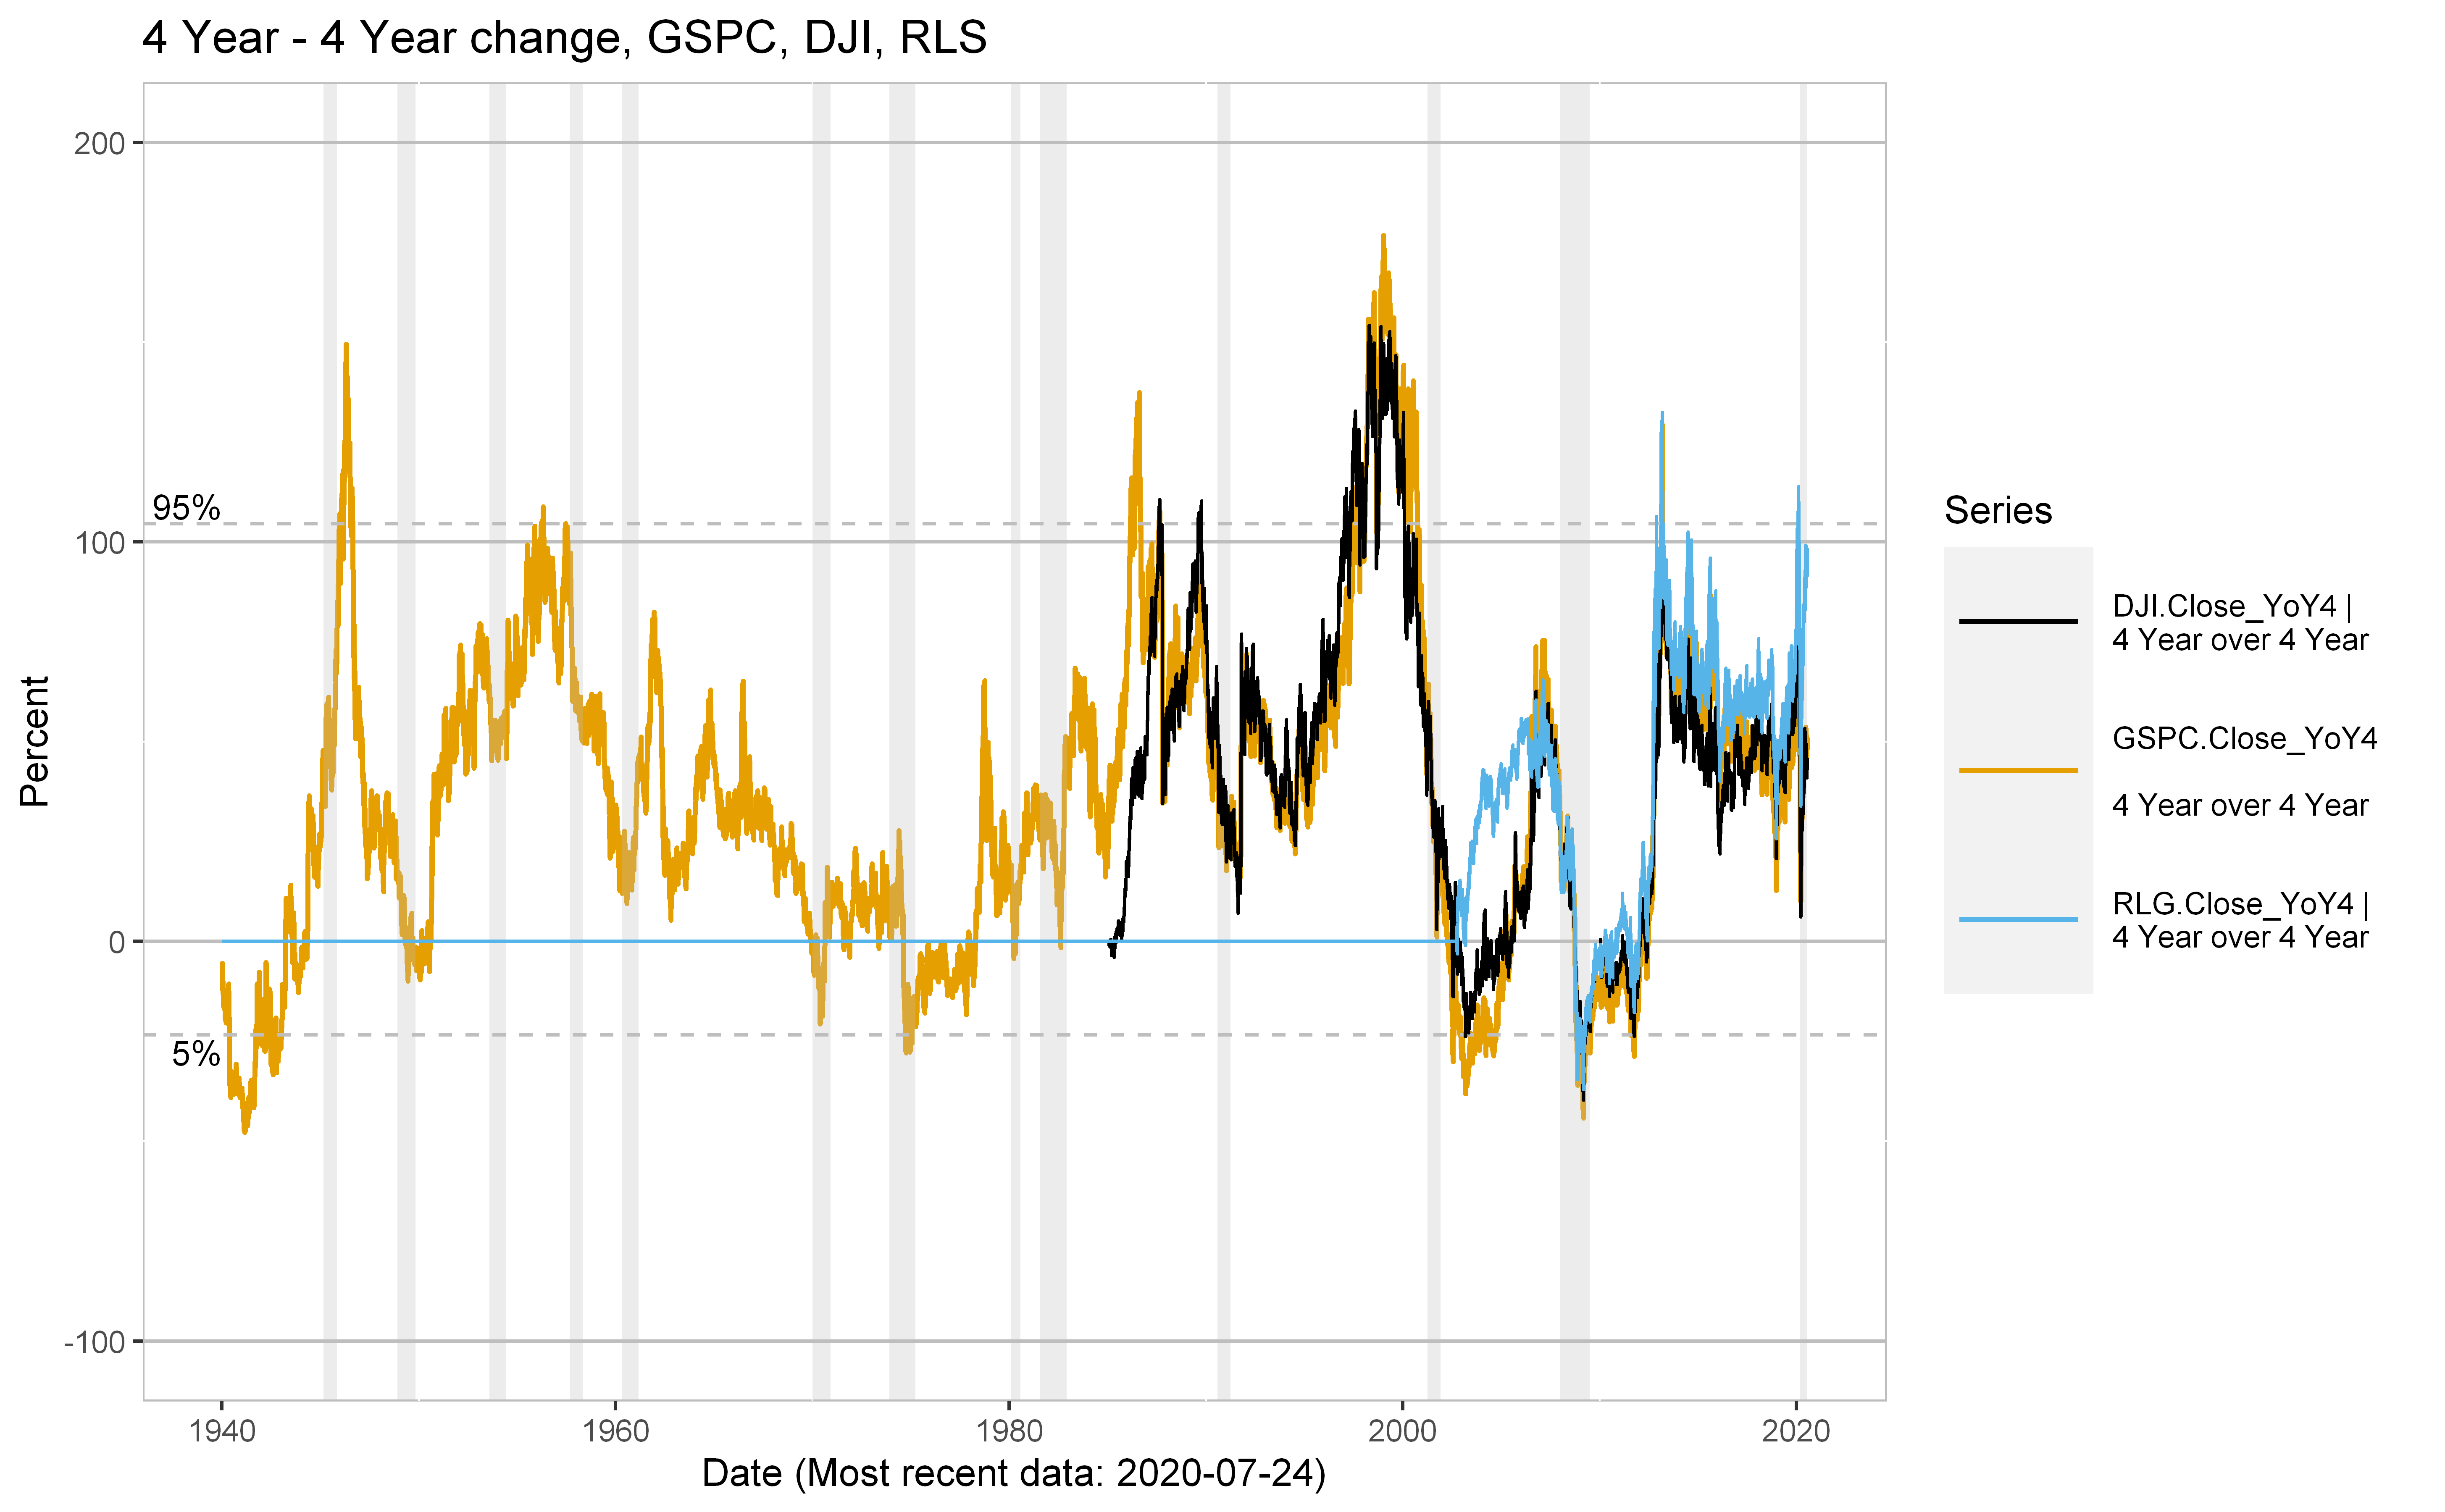

In [73]:
datay.in <- "GSPC.Close_YoY4"
datay.aux.1 <- "DJI.Close_YoY4"
datay.aux.2 <- "RLG.Close_YoY4"
ylim.in <- c(-100, 200)
dt.start <- as.Date('1940-01-01')
p1 <- plotSingle(datadf_rec=dfRecession,
           datadf=df.data,
           datax="date",
           datay = datay.in,
           titlelabel = "4 Year - 4 Year change, GSPC, DJI, RLS",
           xlabel = "Date",
           ylabel = getPlotYLabel(df.symbols, datay.in),
           xlim = c(dt.start, Sys.Date()),
           ylim = ylim.in,
           b.legend = TRUE,
           b.percentile = TRUE,
           b.long.legend = TRUE) 
p1 <-p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
  ),
  na.rm = TRUE
)

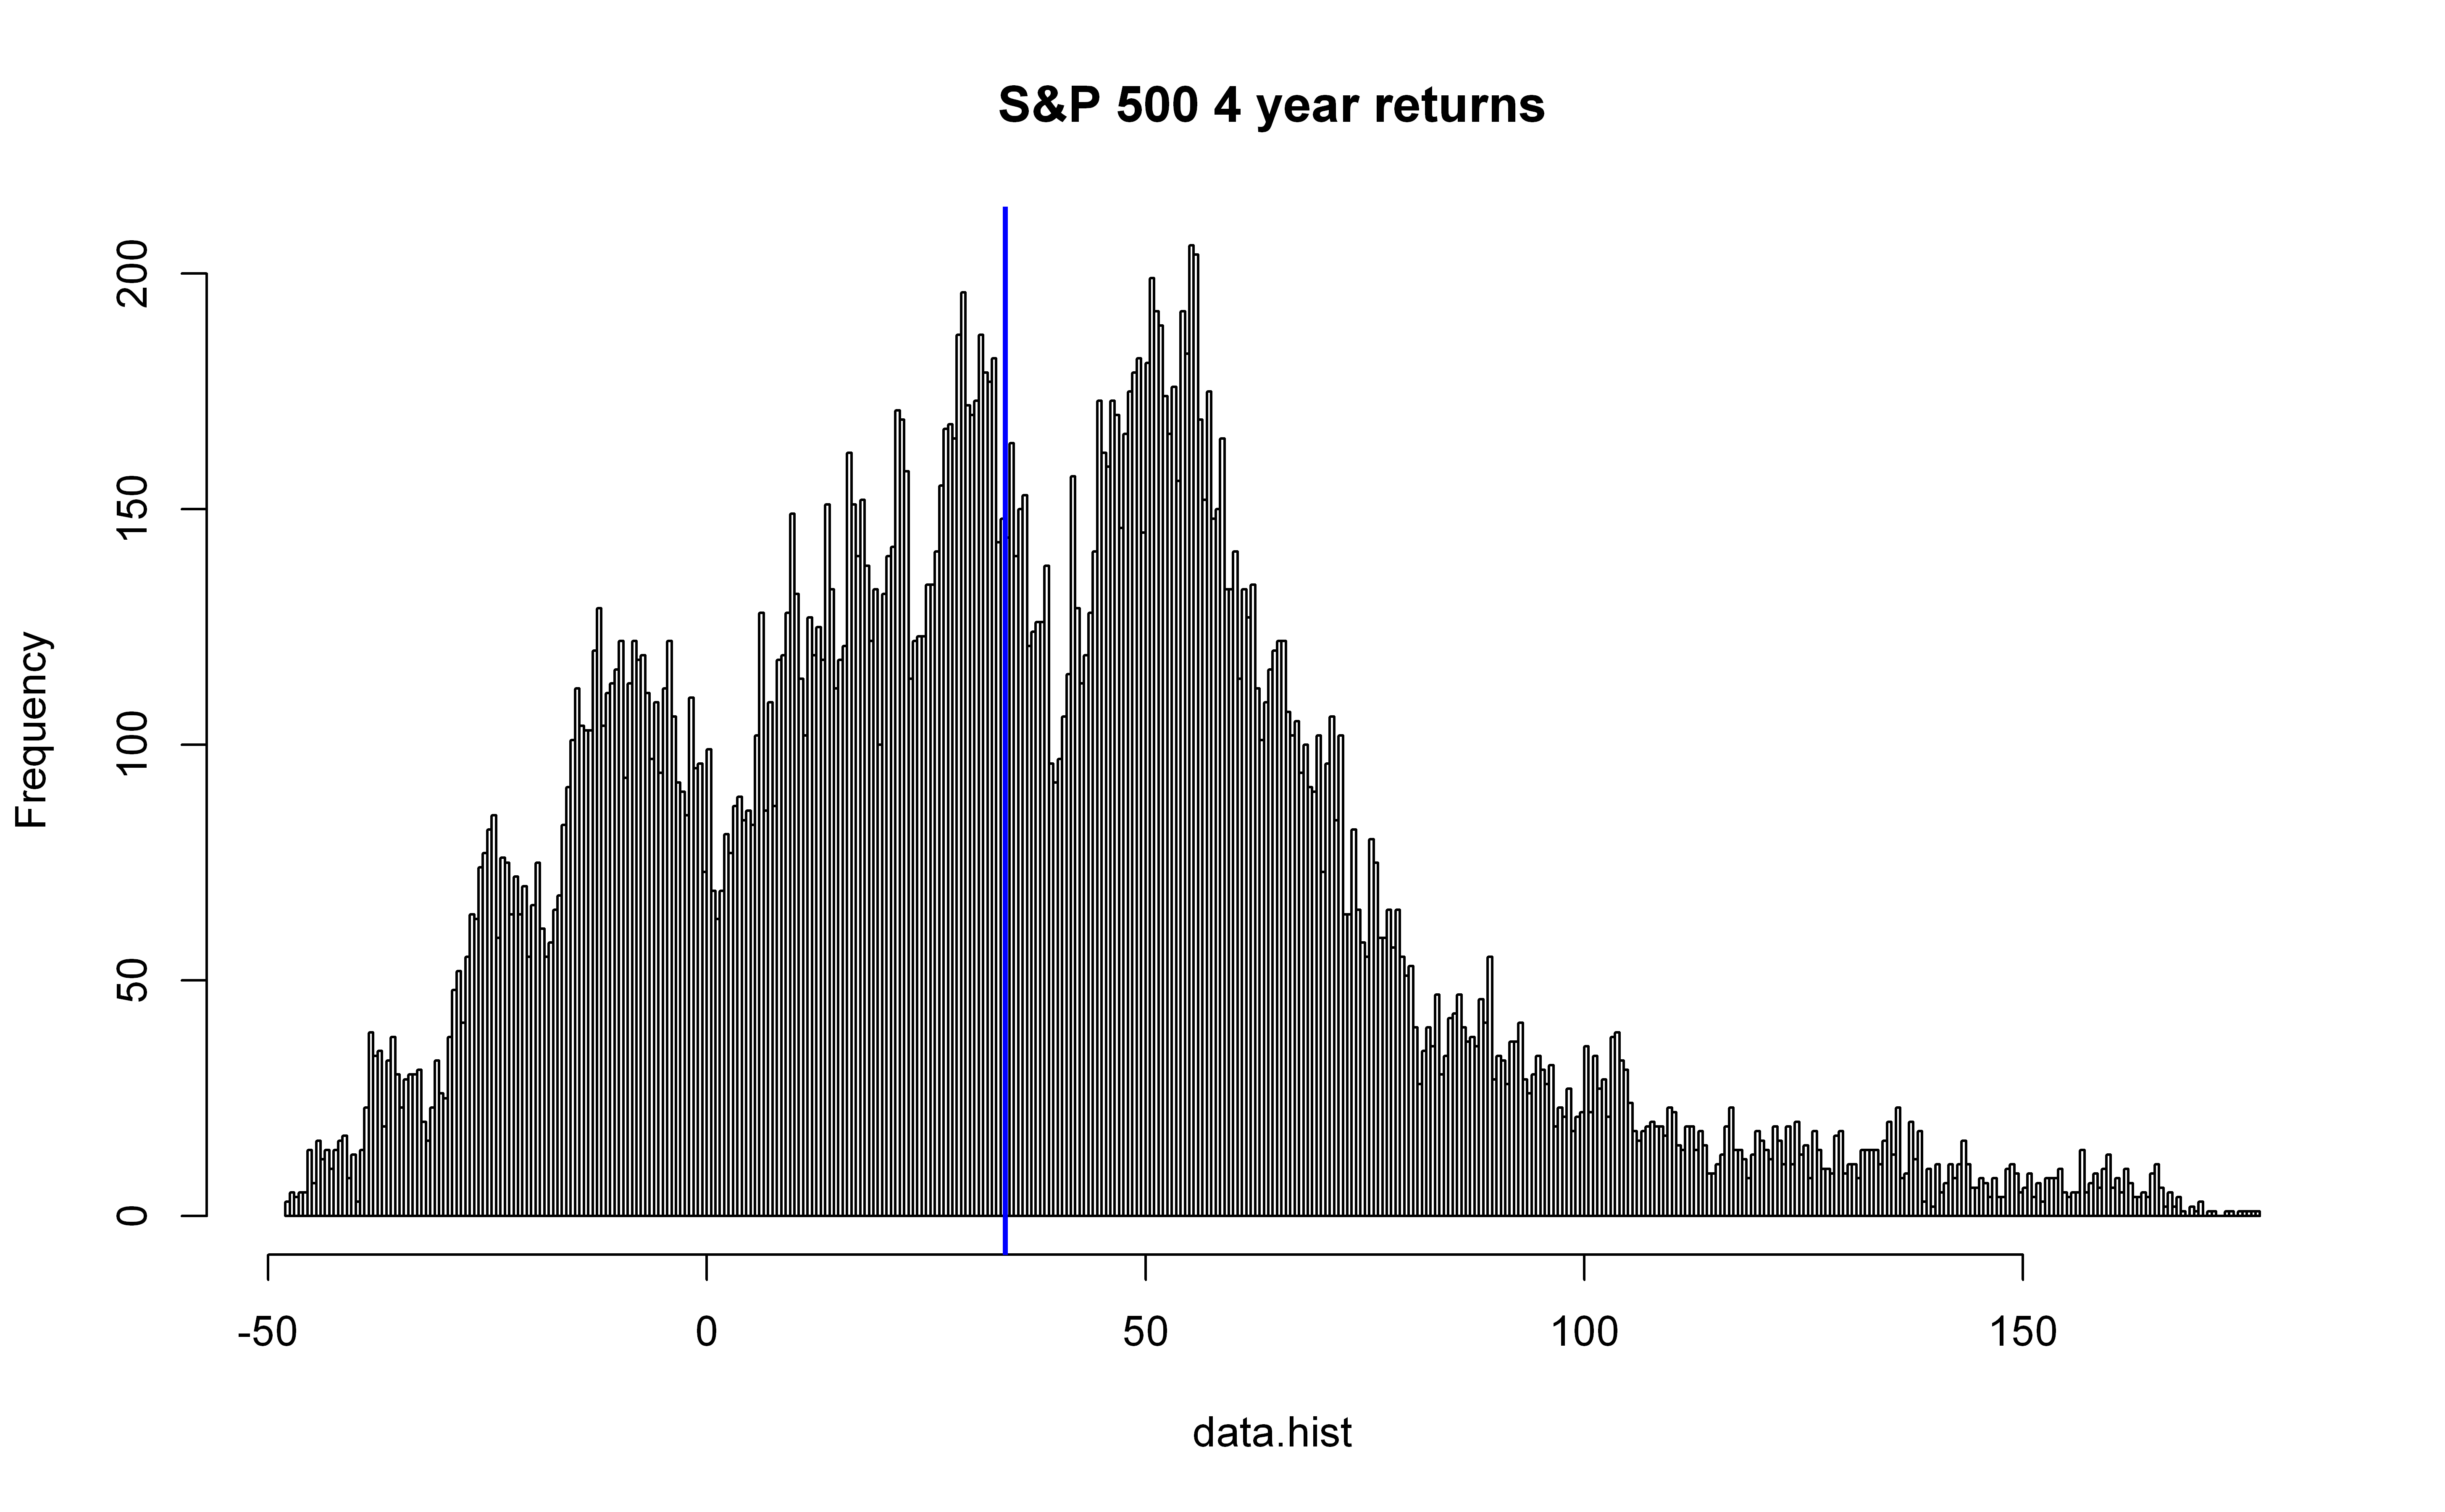

In [77]:
data.hist <- df.data$GSPC.Close_YoY4[df.data$date>dt.start]
my.h <- hist(data.hist,breaks=500,main="S&P 500 4 year returns")
abline(v = median(data.hist), col = "blue", lwd = 2)
my.h$counts=100*my.h$counts/sum(my.h$counts)

Really interested in how likely a 40% decline is 4 years after a peak

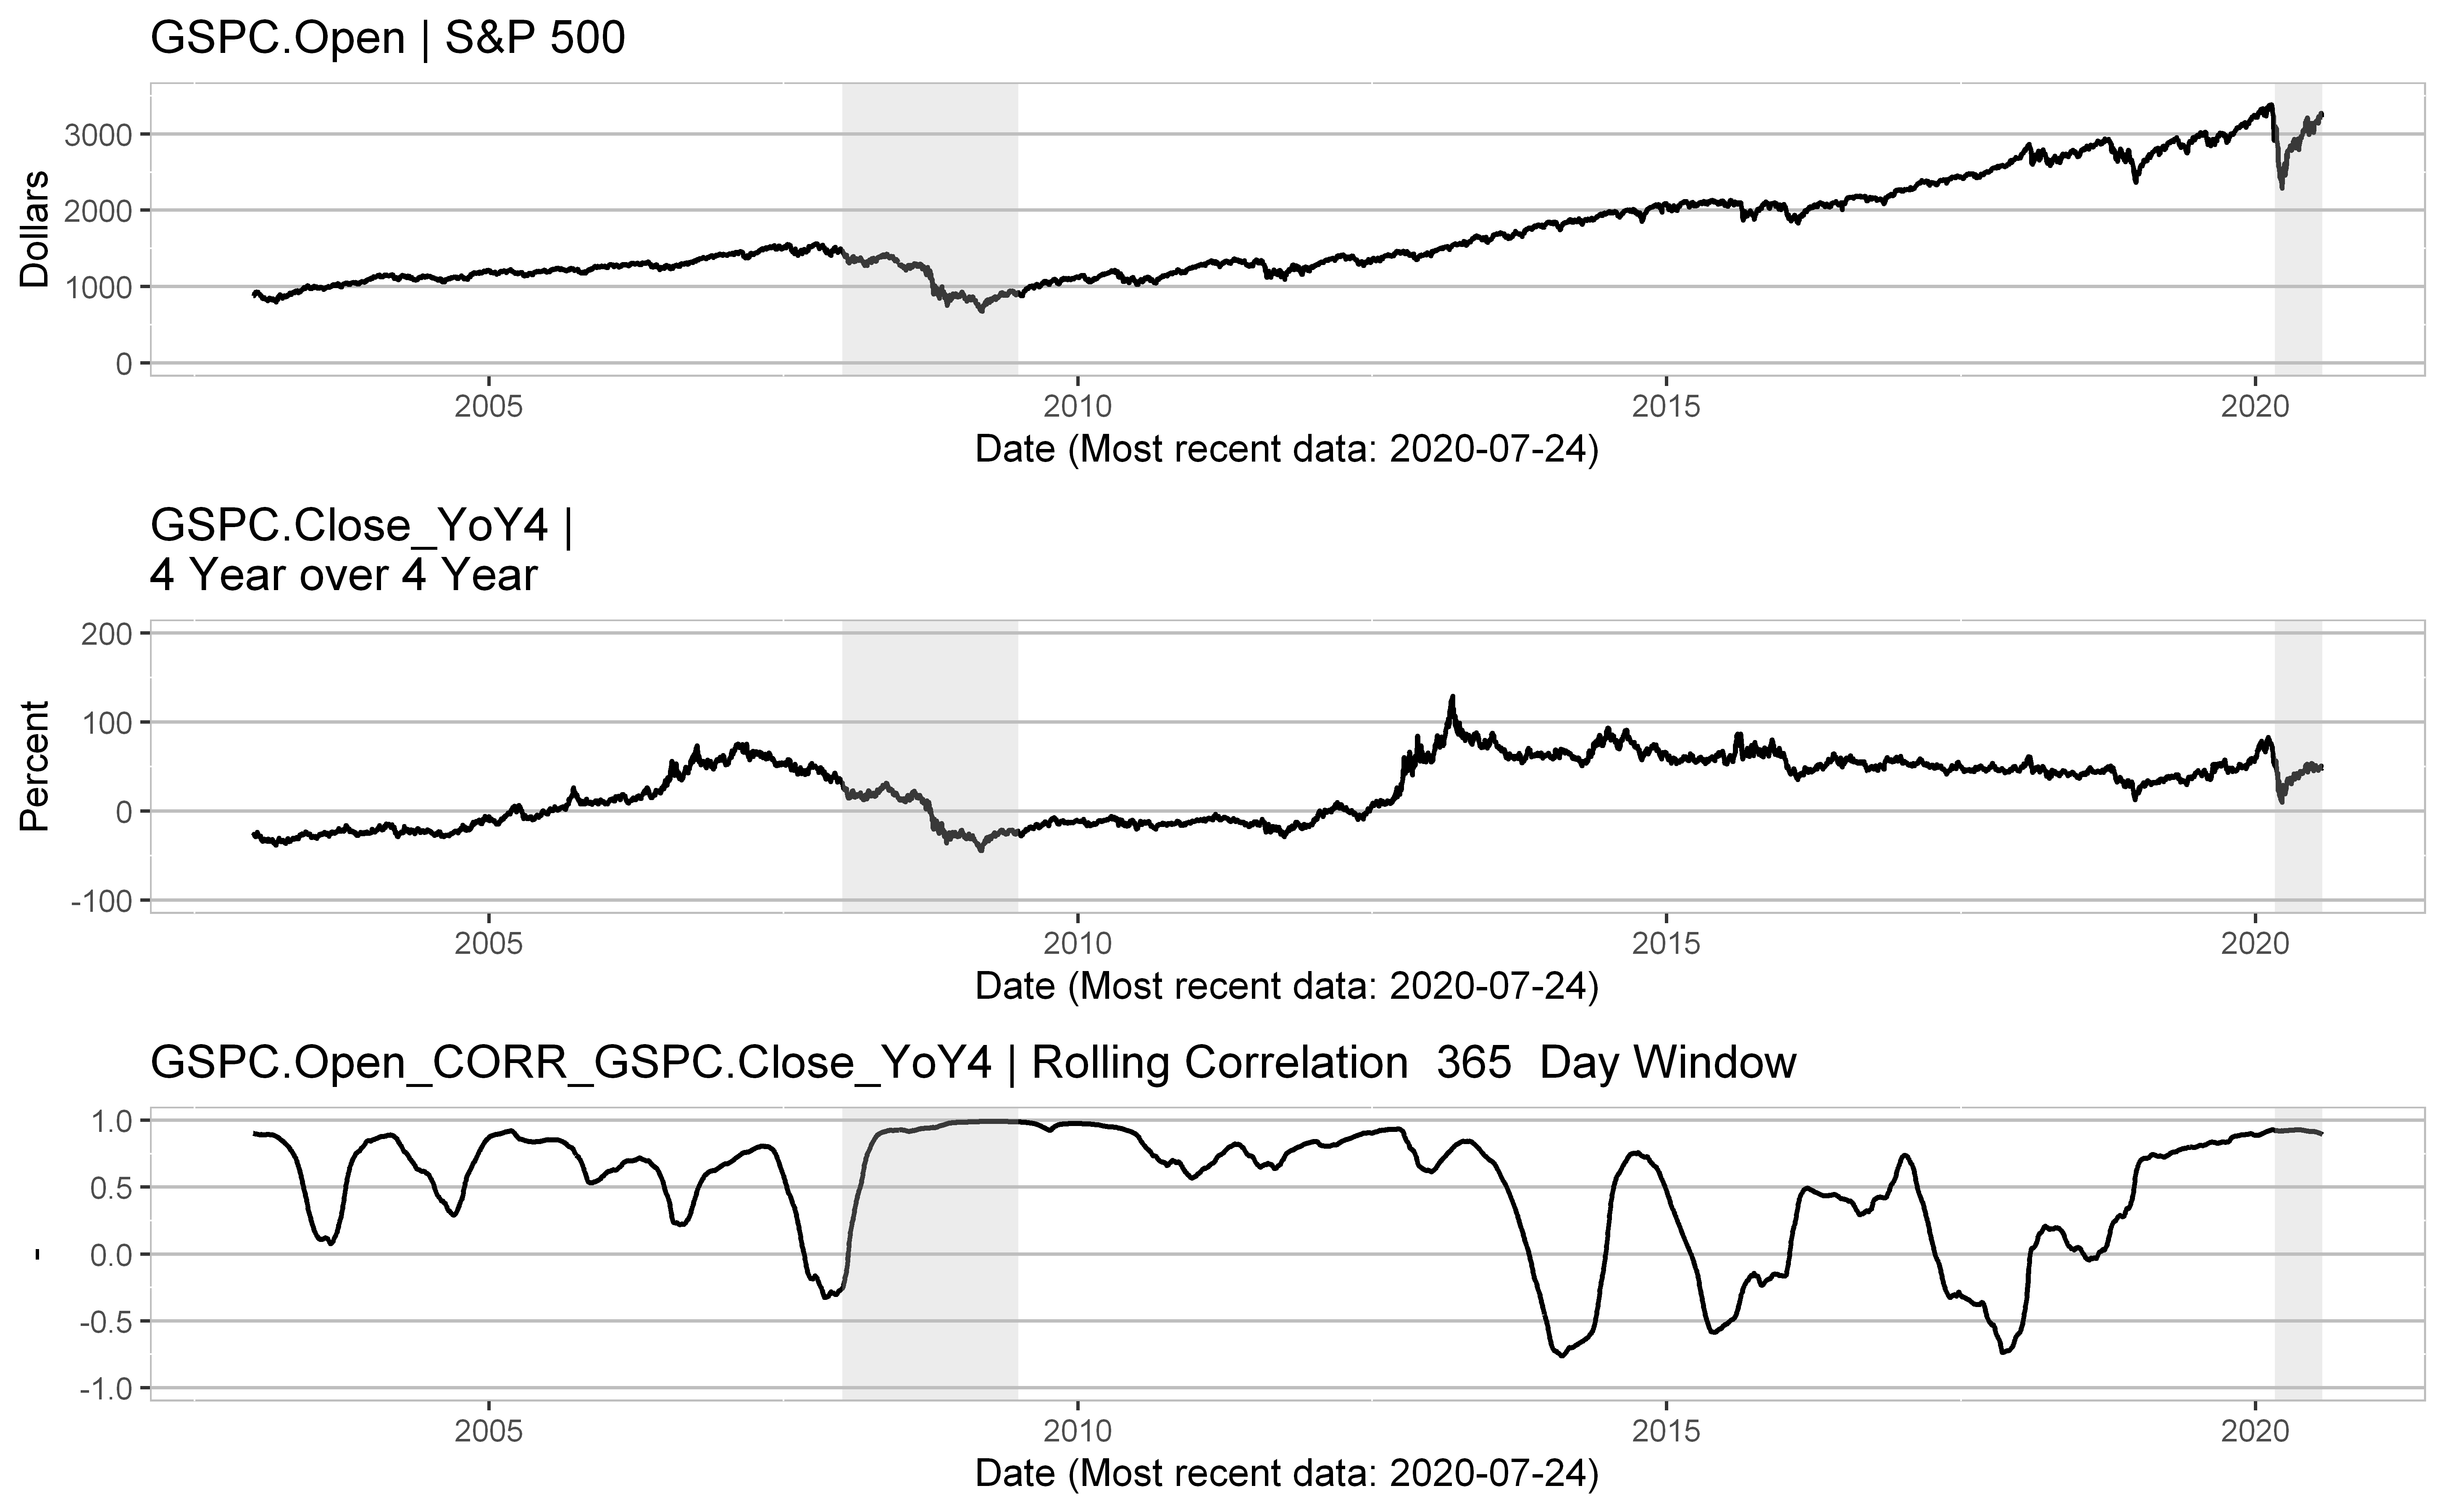

In [90]:
datay1 <- "GSPC.Open"
ylim1 <- c(0, d.GSPC.max)

datay2 <- "GSPC.Close_YoY4"
ylim2 <- c(-100, 200)

dtStart <- as.Date("1jan2003","%d%b%Y")

w <- 365
corrName <- calcRollingCorr(dfRecession, df.data, df.symbols, datay1, ylim1, datay2, ylim2, w, dtStart)


In [80]:
plot( 100*( df.emp.model$CLF16OV.lm.POPTHM -  df.emp.model$NPPTTL ) / df.emp.model$CLF16OV.lm.POPTHM,
     df.emp.model$UNRATE,
     main = "ADP v. U3",
     xlab = "NPPTTL (ADP) normalized by labor force, Percent",
     ylab = "UNRATE (U3), Percent")


ERROR: Error in plot(100 * (df.emp.model$CLF16OV.lm.POPTHM - df.emp.model$NPPTTL)/df.emp.model$CLF16OV.lm.POPTHM, : object 'df.emp.model' not found


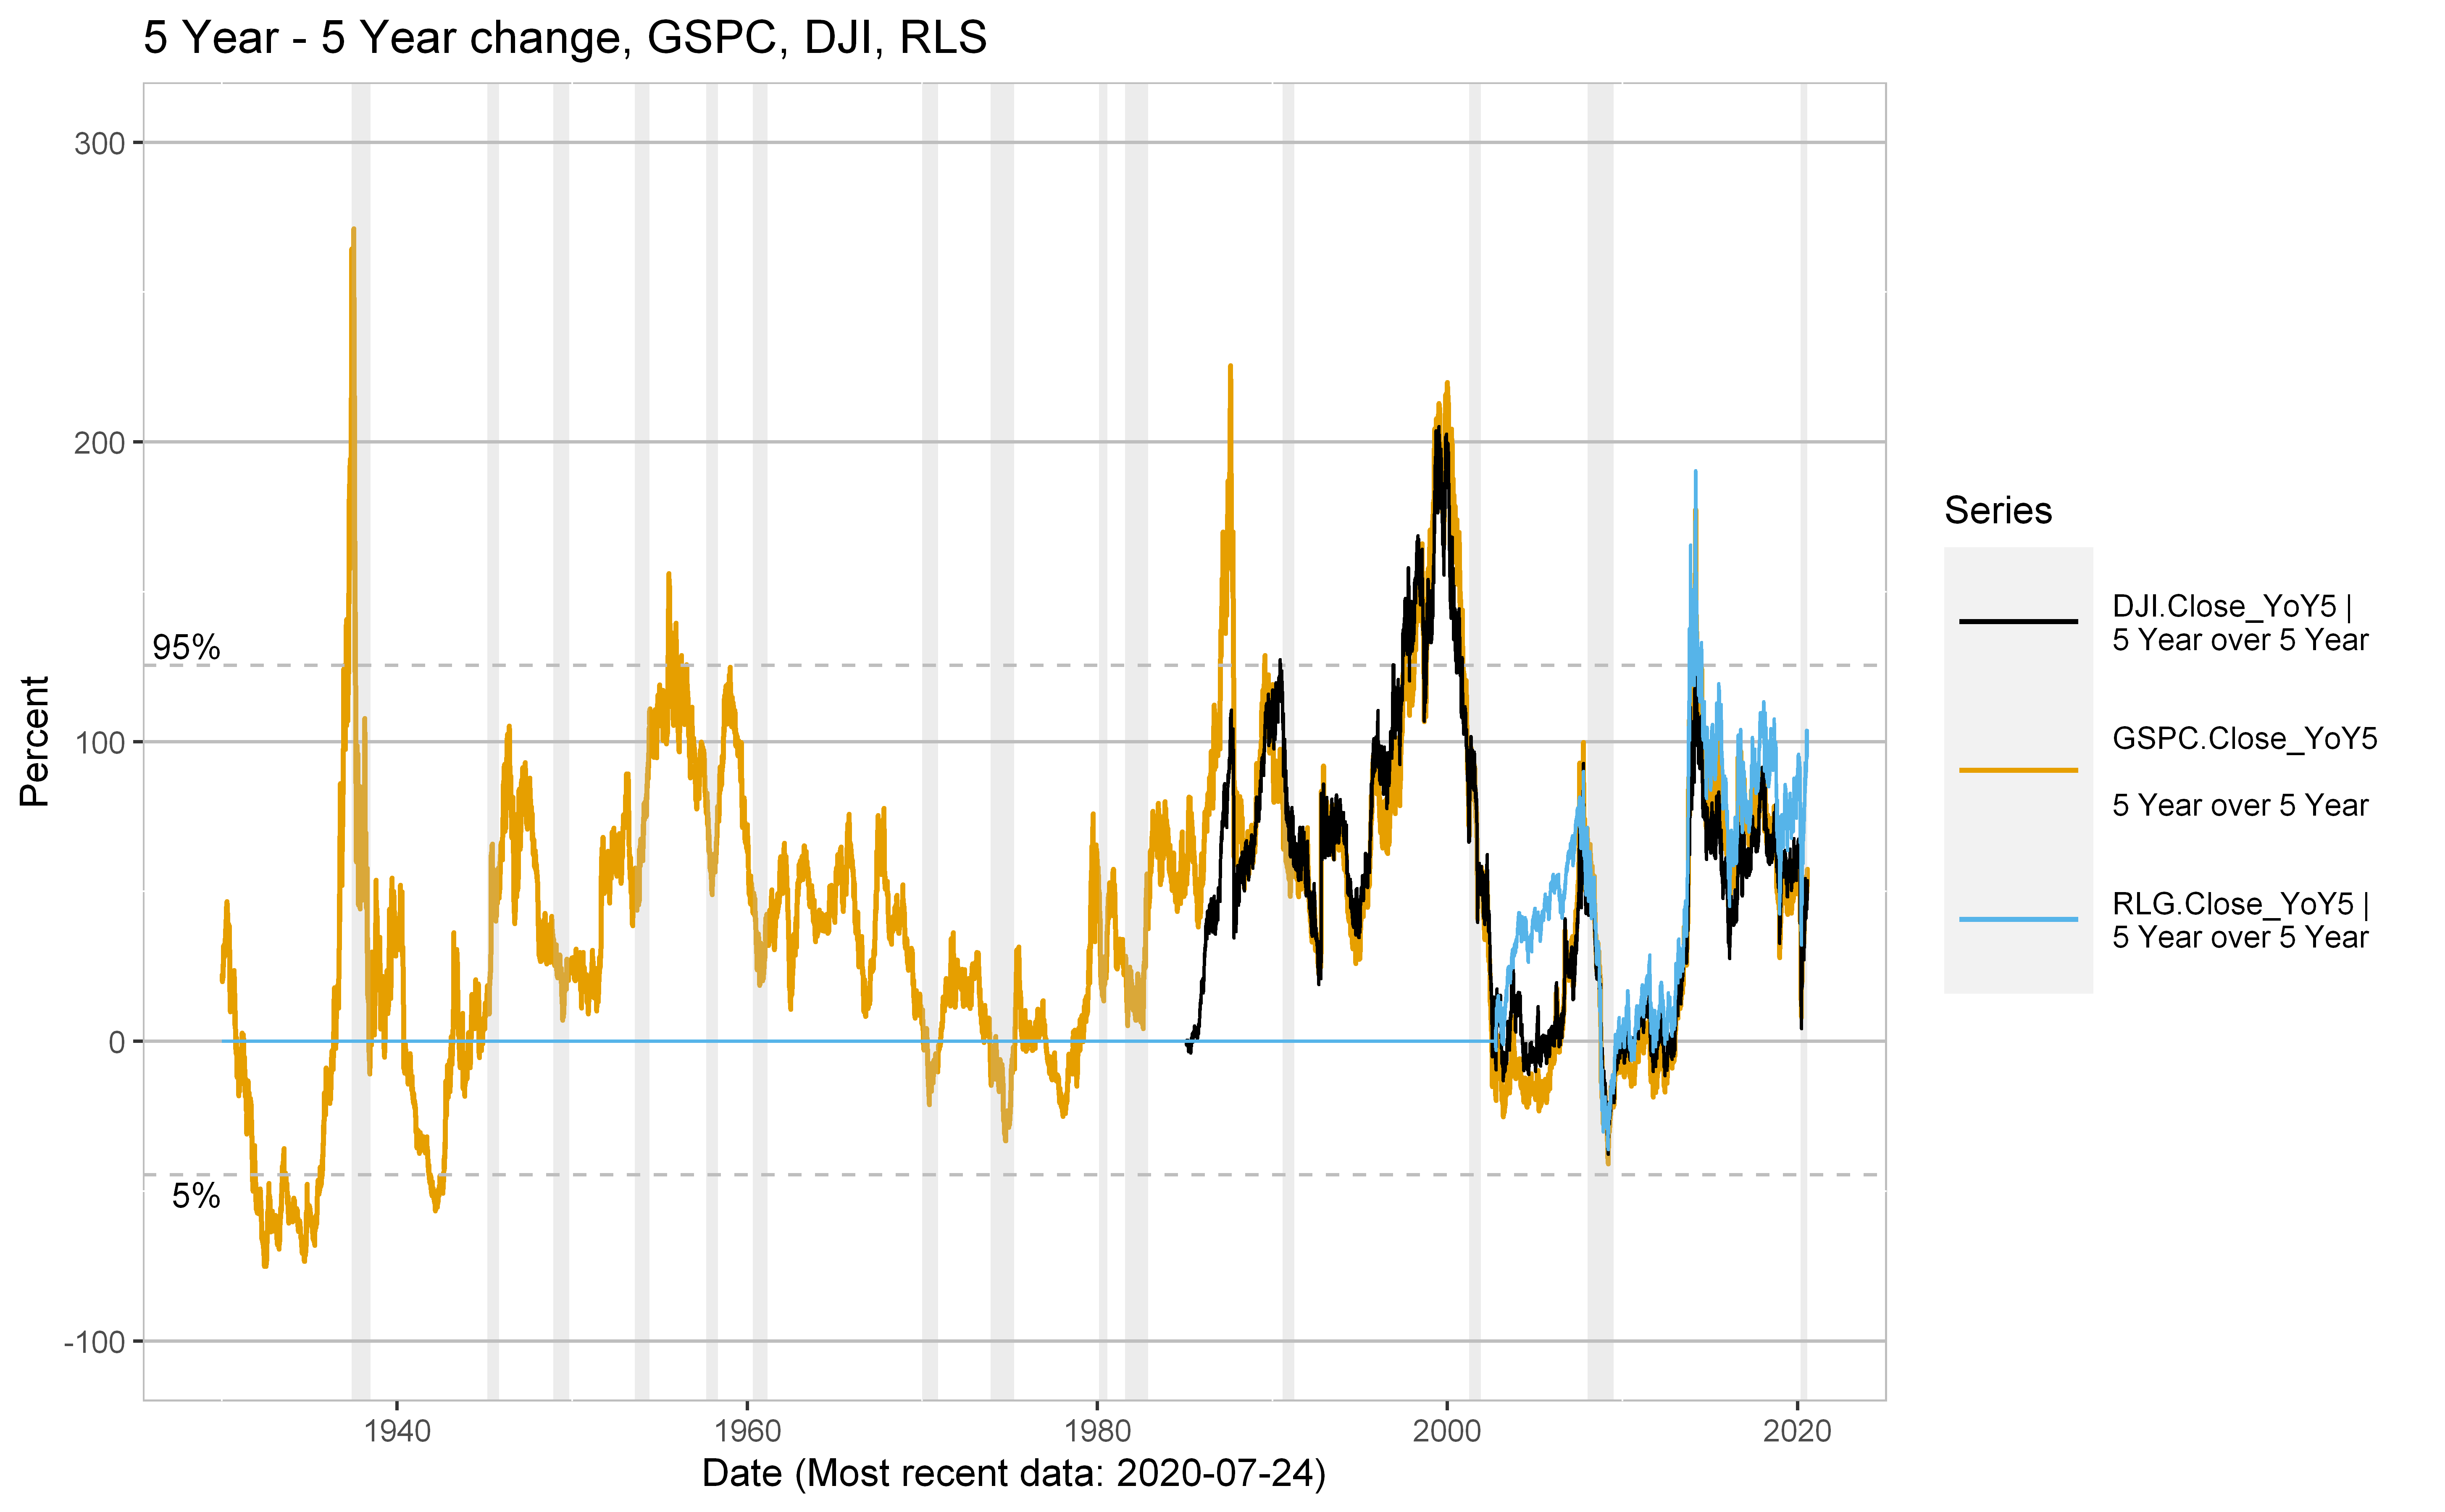

In [78]:
datay.in <- "GSPC.Close_YoY5"
datay.aux.1 <- "DJI.Close_YoY5"
datay.aux.2 <- "RLG.Close_YoY5"
ylim.in <- c(-100, 300)
dt.start <- as.Date('1930-01-01')
p1 <- plotSingle(datadf_rec=dfRecession,
           datadf=df.data,
           datax="date",
           datay = datay.in,
           titlelabel = "5 Year - 5 Year change, GSPC, DJI, RLS",
           xlabel = "Date",
           ylabel = getPlotYLabel(df.symbols, datay.in),
           xlim = c(dt.start, Sys.Date()),
           ylim = ylim.in,
           b.legend = TRUE,
           b.percentile = TRUE,
           b.long.legend = TRUE) 
p1 <-p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
  ),
  na.rm = TRUE
)

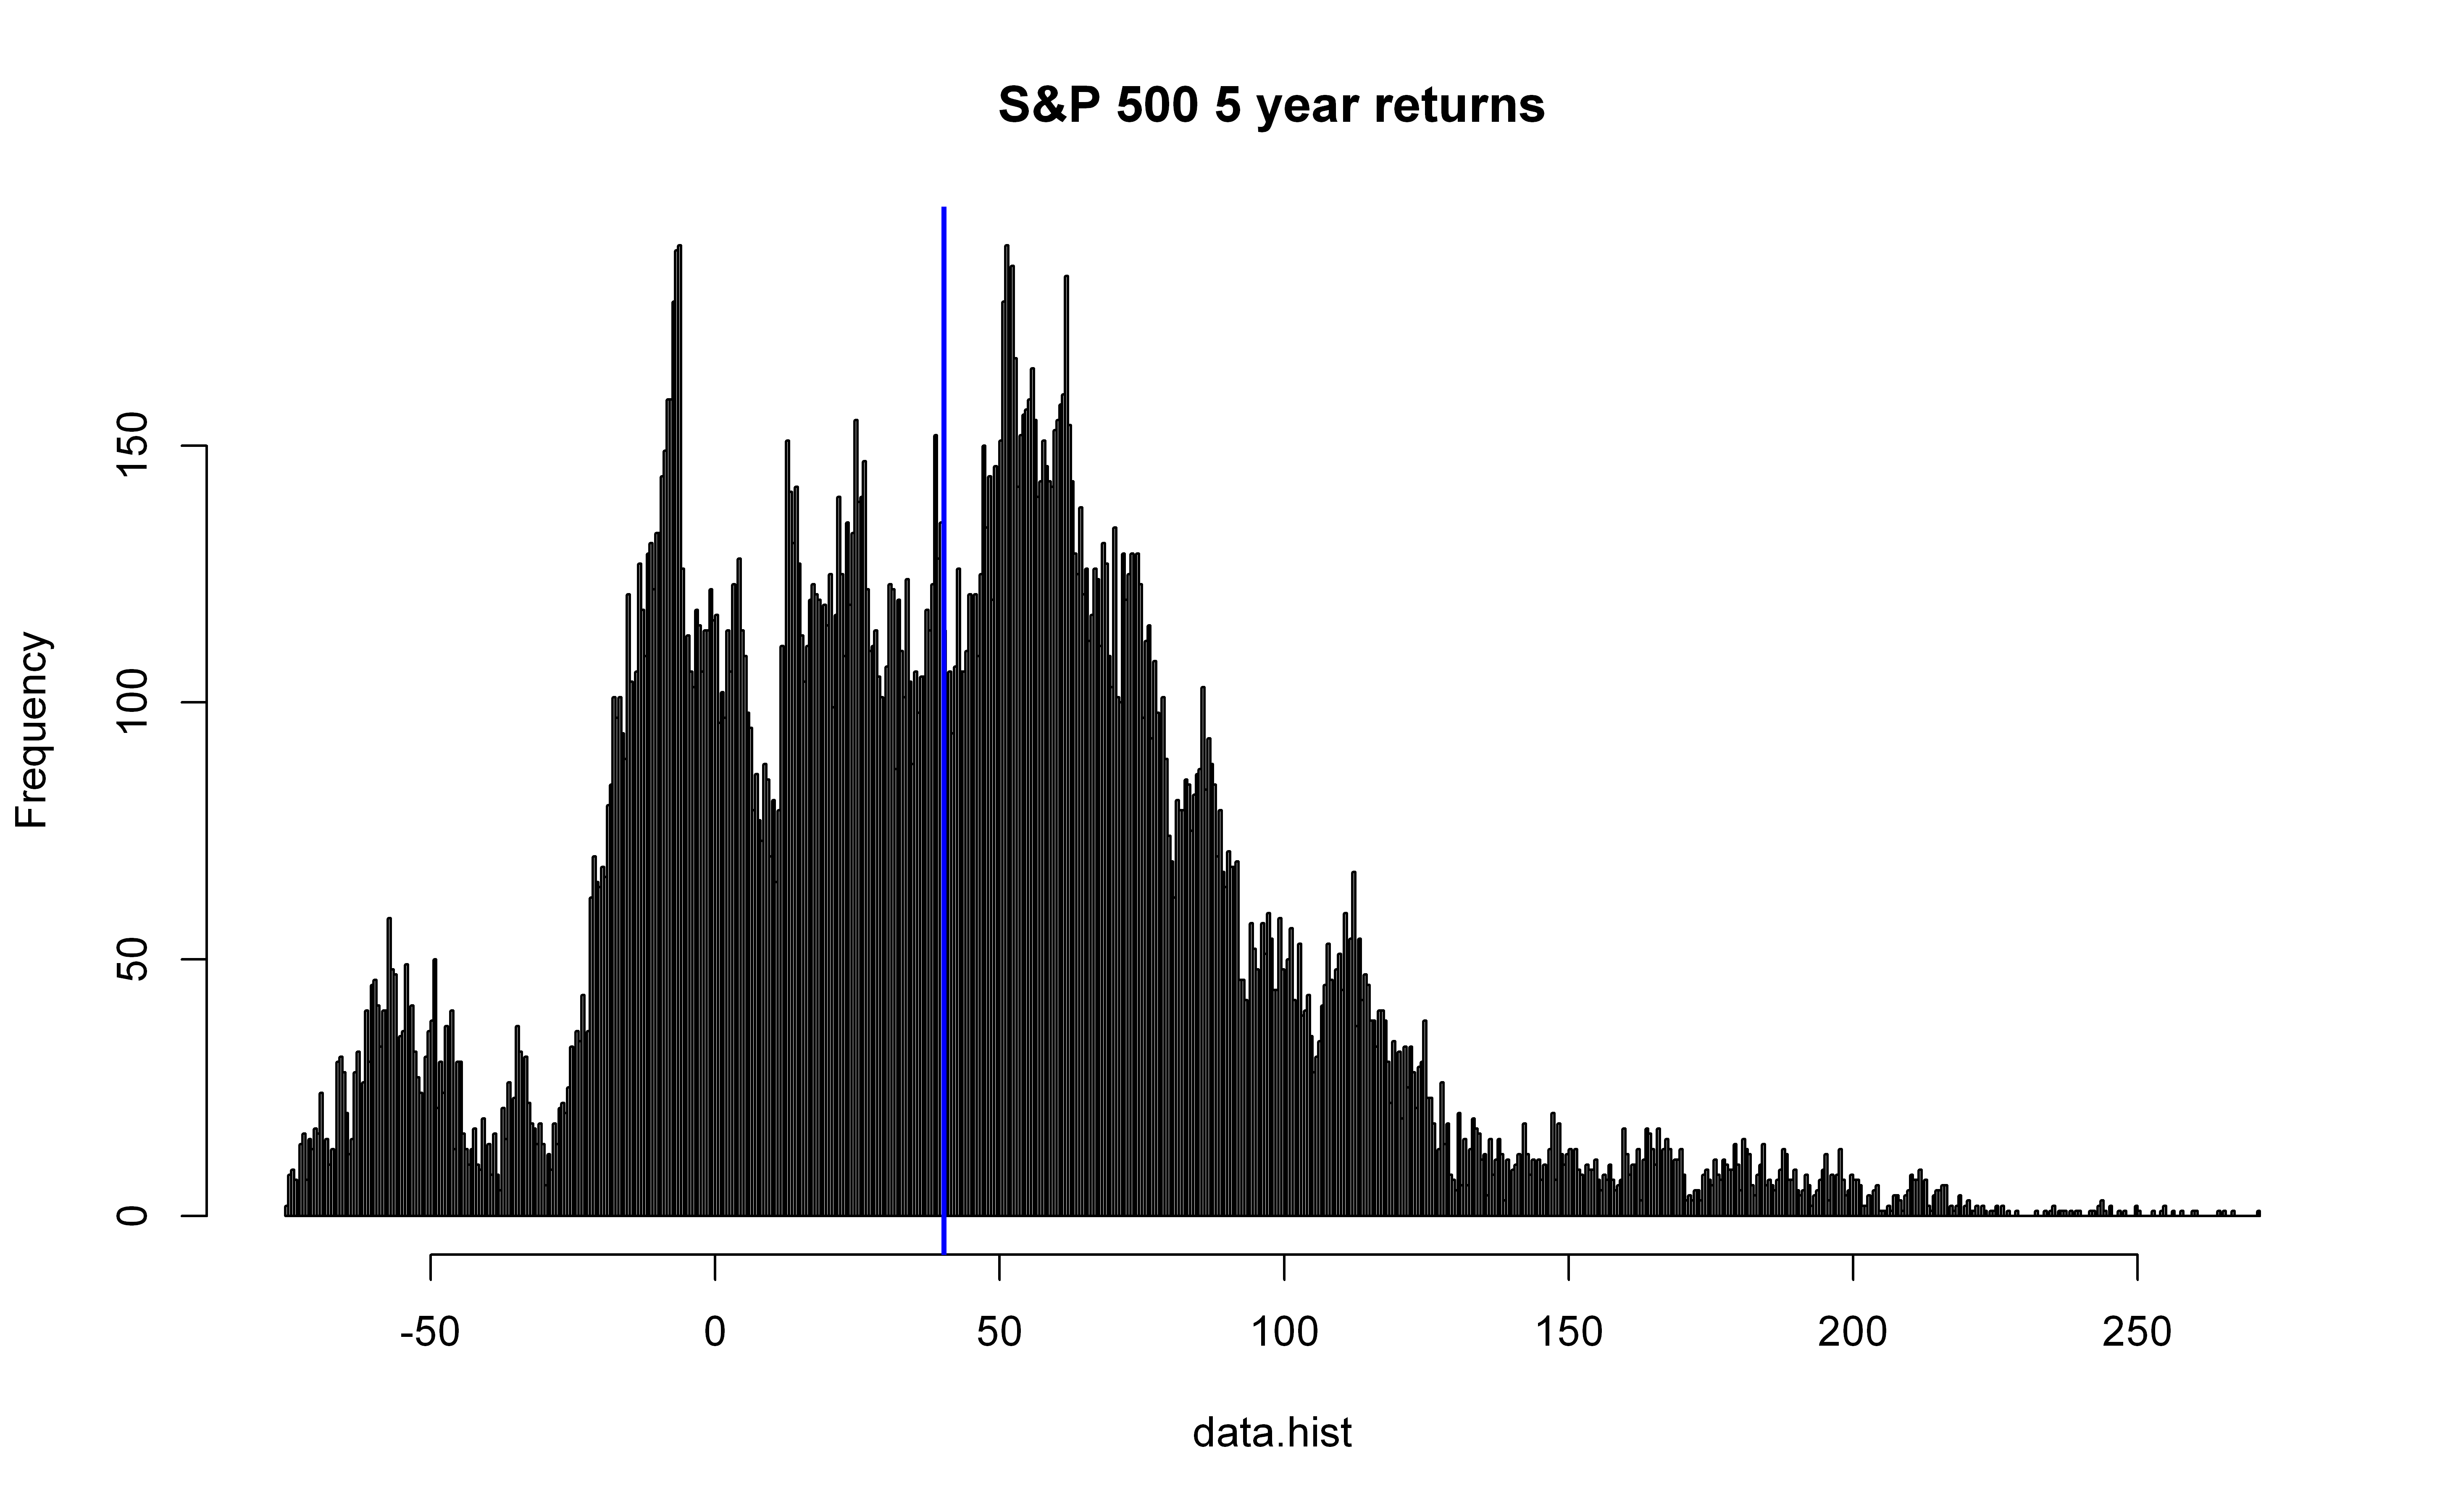

In [79]:
data.hist <- df.data$GSPC.Close_YoY5[df.data$date>dt.start]
my.h <- hist(data.hist,breaks=500,main="S&P 500 5 year returns")
abline(v = median(data.hist), col = "blue", lwd = 2)
my.h$counts=100*my.h$counts/sum(my.h$counts)

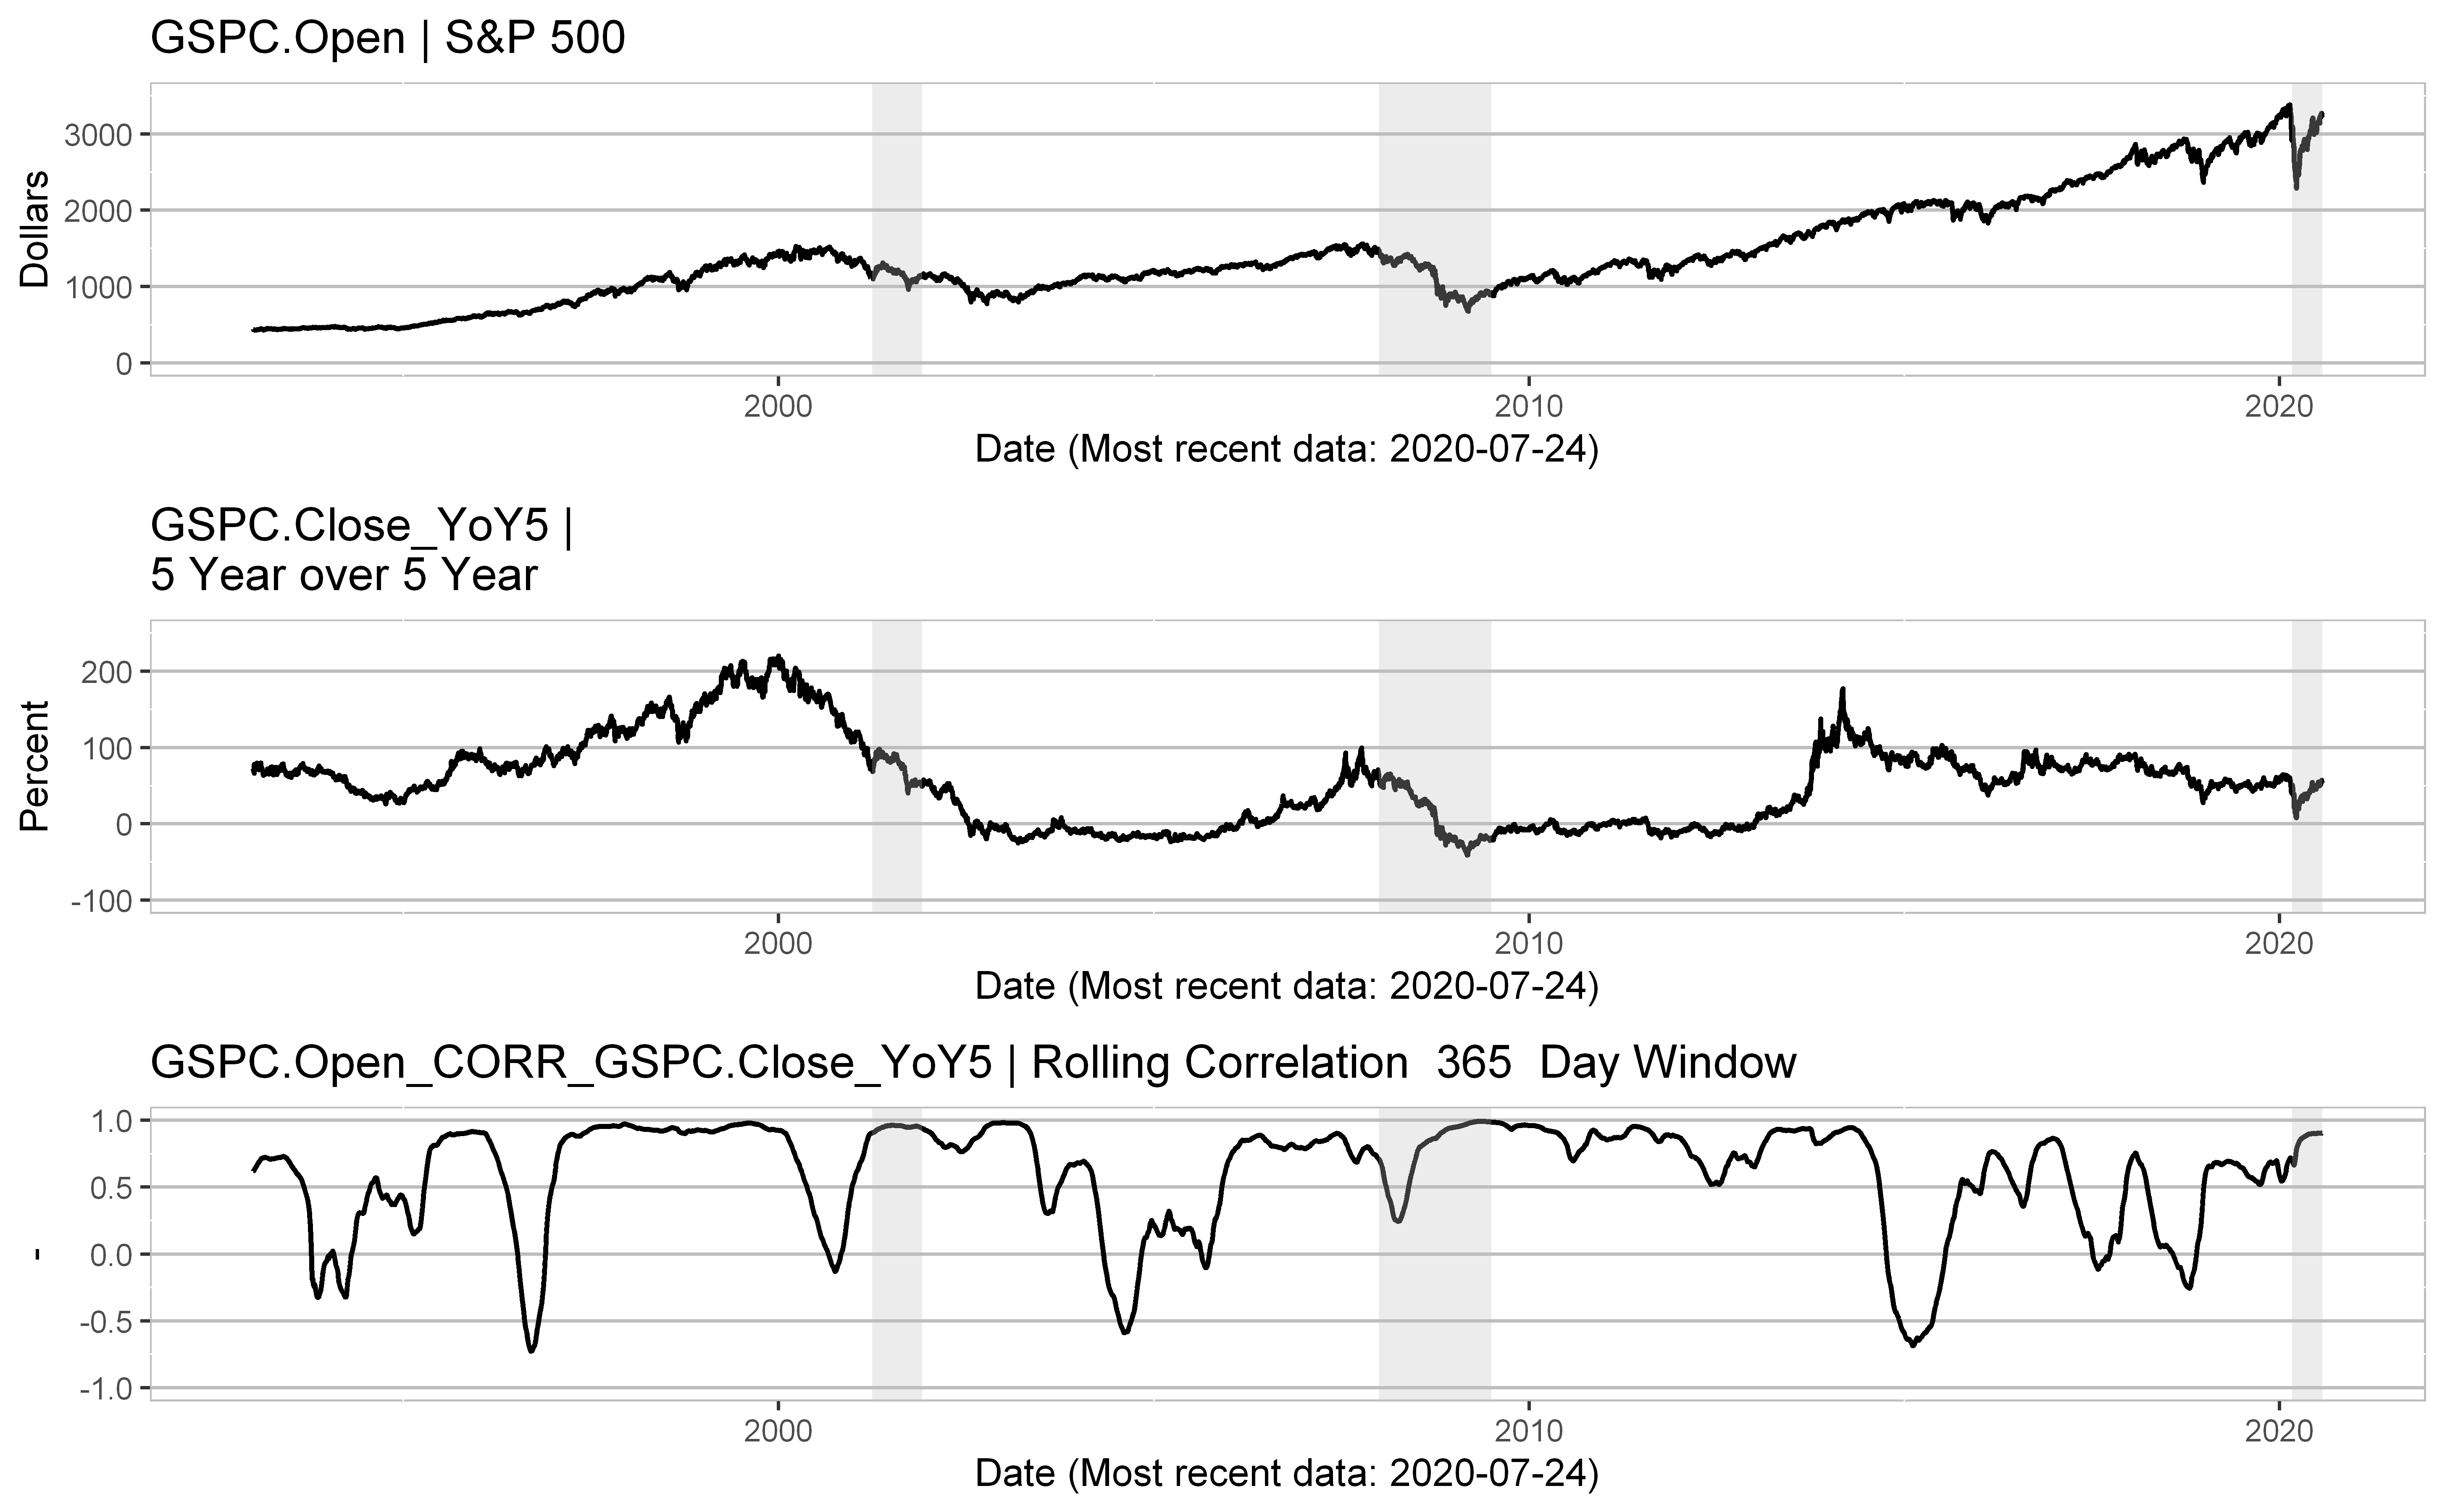

In [94]:
datay1 <- "GSPC.Open"
ylim1 <- c(0, d.GSPC.max)

datay2 <- "GSPC.Close_YoY5"
ylim2 <- c(-100, 250)

dtStart <- as.Date("1jan1993","%d%b%Y")

w <- 365
corrName <- calcRollingCorr(dfRecession, df.data, df.symbols, datay1, ylim1, datay2, ylim2, w, dtStart)


Compare the 1-, 4- and 5- year returns for the S&P

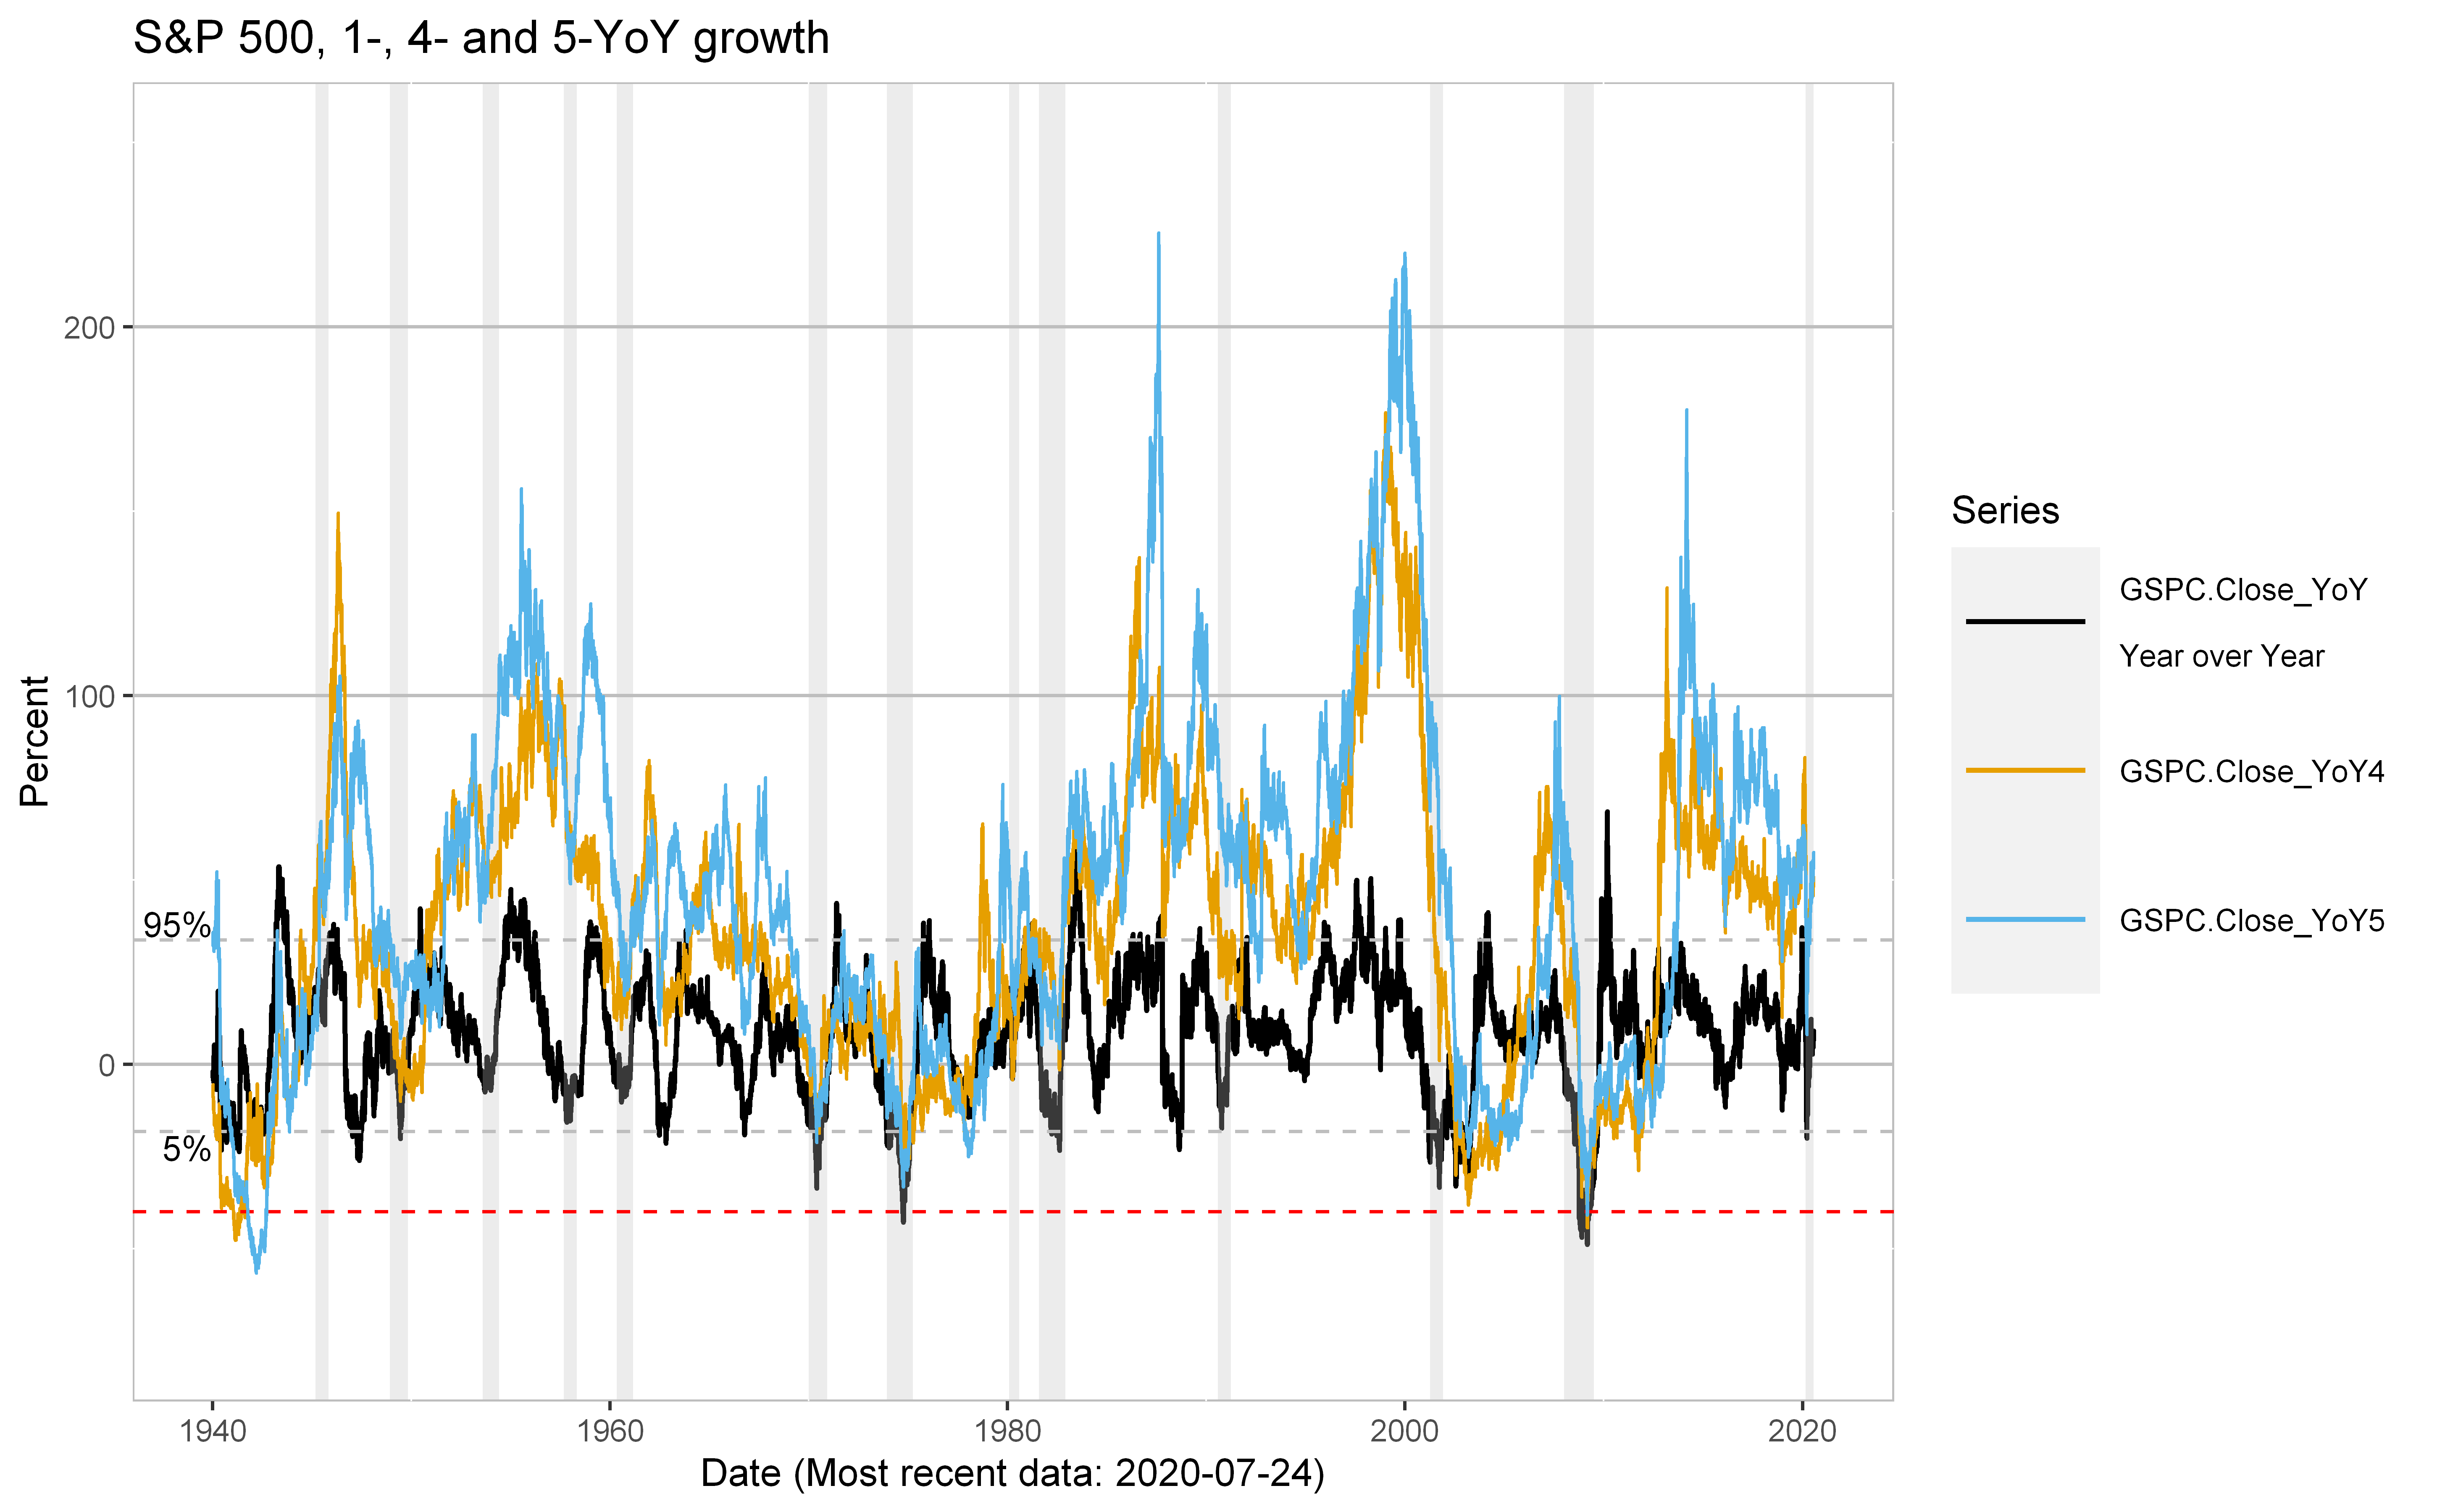

In [109]:
datay.in <- "GSPC.Close_YoY"
datay.aux.1 <- "GSPC.Close_YoY4"
datay.aux.2 <- "GSPC.Close_YoY5"
ylim.in <- c(-75, 250)
dt.start <- as.Date('1940-01-01')
p1 <- plotSingle(datadf_rec=dfRecession,
           datadf=df.data,
           datax="date",
           datay = datay.in,
           titlelabel = "S&P 500, 1-, 4- and 5-YoY growth",
           xlabel = "Date",
           ylabel = getPlotYLabel(df.symbols, datay.in),
           xlim = c(dt.start, Sys.Date()),
           ylim = ylim.in,
           b.legend = TRUE,
           b.percentile = TRUE,
           b.long.legend = TRUE) 
p1 <-p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = df.data[[datay.aux.1]],
    colour = shQuote(datay.aux.1)
  ),
  na.rm = TRUE
)
p1 <-p1 + geom_hline(yintercept = -40,
                             linetype = "dashed",
                             color = "red")

p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(datay.aux.2)
  ),
  na.rm = TRUE
)

In [101]:
tail(df.data[[datay.aux.1]])

[1] 50.77088 49.06319 48.28958 48.24173 48.41962 48.18161

In [104]:
2.0^0.25

[1] 1.189207

In [111]:
1.5^0.2

[1] 1.084472